In [1]:
import pandas as pd
import prepare

import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

# Set alpha significance level to 0.05
alpha = 0.05

# Superstore Time Series Project: Where should we go with our product strategy?

### The goal of this project was to come up with recommendations for the VP of Product related to the following questions:
- Which product line should we expand?
- Is there a product category that is particularly profitable?
- __What product category is least profitable, why?__
- Does one or anther stand out in terms of sales volume?
- How do these relationships change if we control for customer segment?


## Acquiring and Preparing the data from the superstore_db, which is stored on the cloud server.
- SUMMARIZE ACQUIRE AND PREPARE STEPS

In [2]:
df = prepare.prepare_superstore_data()

Reading csv file..


## Exploration Results

### Data contains sales and profit information for 3 categories of products

In [28]:
df.groupby("category").profit.mean().sort_values(ascending=False)

category
Technology         60.349043
Office Supplies    18.305621
Furniture          -1.731236
Name: profit, dtype: float64

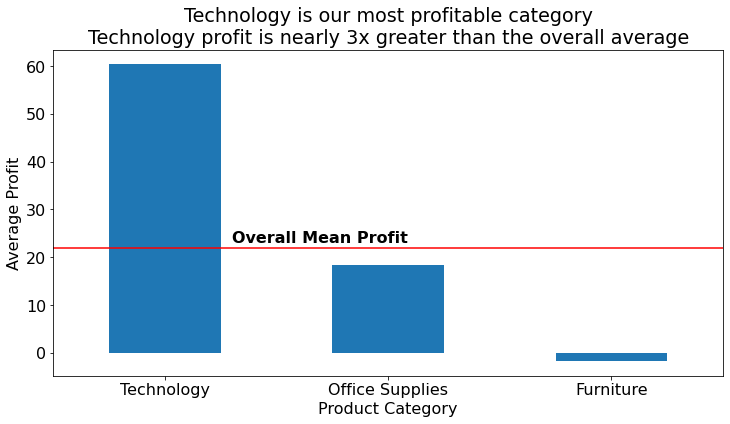

In [3]:
df.groupby("category").profit.mean().sort_values(ascending=False).plot.bar()
plt.title('Technology is our most profitable category\nTechnology profit is nearly 3x greater than the overall average')
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(0.3,23), fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel("Product Category")
plt.ylabel("Average Profit")
plt.show()

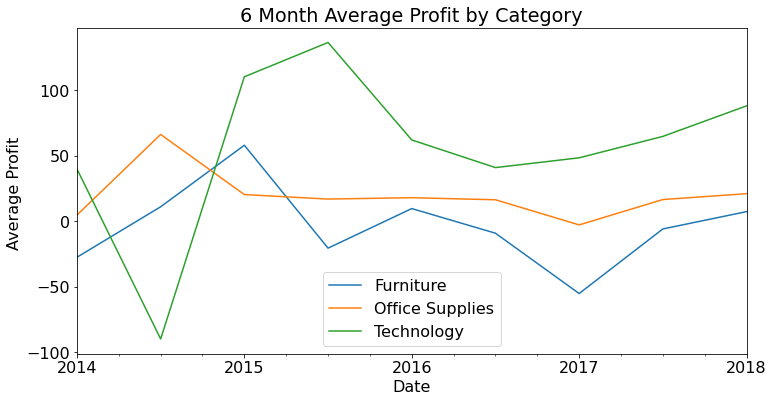

In [30]:
# Profit of categories over time 
for cat in df.category.unique():
    sample = df[df.category == cat]
    sample.resample('6M').profit.mean().plot(label = cat)
    plt.title('6 Month Average Profit by Category')
    plt.ylabel('Average Profit ')
    plt.xlabel('Date')
    plt.legend()
# plt.axhline(mean_profit, color='r')


### Technology profitability is on the rise while furniture and office supplies are fairly stagnant

In [6]:
for cat in df["category"].unique():
    overall_mean = df.profit.mean()
    print(overall_mean)
    sample = df[df["category"] == cat].profit
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(cat, "samples: ",len(sample), "t:", round(t,2), "p", round(p,4), "cat mean",round(sample.mean(),2))
    if (t>0)&(p/2<alpha):
        print("Significant Higher ", cat)
    if (t<0)&(p/2<alpha):
        print("Significant Lower ", cat)

21.88035138408307
Furniture samples:  360 t: -2.74 p 0.0065 cat mean -1.73
Significant Lower  Furniture
21.88035138408307
Office Supplies samples:  1055 t: -0.82 p 0.4133 cat mean 18.31
21.88035138408307
Technology samples:  319 t: 1.94 p 0.0531 cat mean 60.35
Significant Higher  Technology


### Technology is significantly more profitable than the overall average and is the only category more profitable than average

### Taking a look at subcategories

Text(1, 200, 'Copiers and Accessories are the big winners')

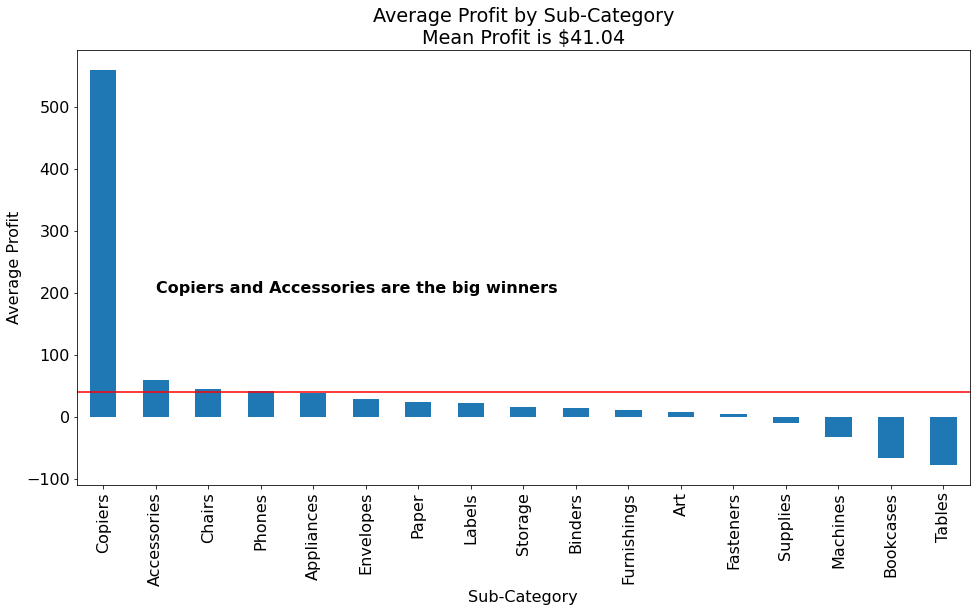

In [32]:
mean_profit = df.groupby("sub_category").profit.mean().mean()
plt.figure(figsize=(16,8))
df.groupby("sub_category").profit.mean().sort_values(ascending=False).plot.bar()
plt.title(f'Average Profit by Sub-Category\nMean Profit is ${mean_profit:.2f}')
plt.xlabel('Sub-Category')
plt.ylabel('Average Profit')
plt.axhline(mean_profit, color='r')
plt.annotate('Copiers and Accessories are the big winners', xy=(1,200), fontweight='bold')

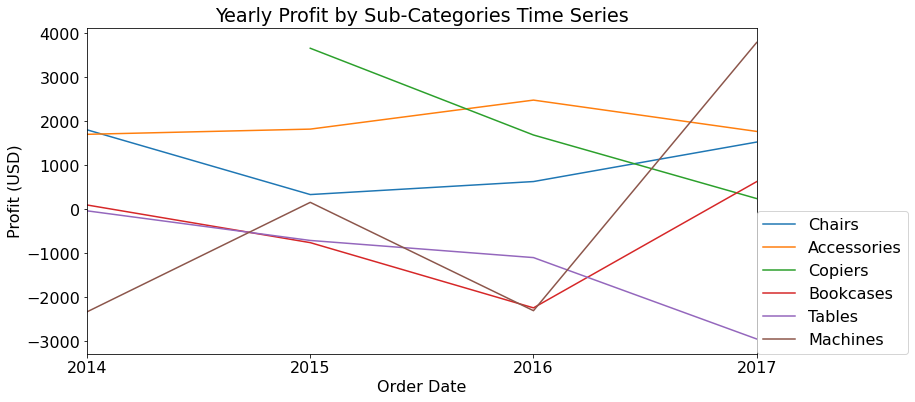

In [9]:
# Profit of categories over time 
# Sub df with profitable sub-categories 
profitable_sub_cat = df[(df.sub_category == 'Chairs') |(df.sub_category == 'Copiers') |(df.sub_category == 'Accessories')]
least_profitable_sub_cat = df[(df.sub_category == 'Machines') |(df.sub_category == 'Bookcases') |(df.sub_category == 'Tables')]

# Sub-category profit every 6 months 

for cat in profitable_sub_cat.sub_category.unique():
    sample = profitable_sub_cat[profitable_sub_cat.sub_category == cat]
    sample.resample('y').profit.sum().plot(label = cat)
    plt.ylabel('Profit (USD)')
    plt.xlabel('Order Date')
    plt.legend(loc = (1.0, 0.0))
    
for cat in least_profitable_sub_cat.sub_category.unique():
    sample = least_profitable_sub_cat[least_profitable_sub_cat.sub_category == cat]
    sample.resample('y').profit.sum().plot(label = cat)
    plt.title('Yearly Profit by Sub-Categories Time Series')
    plt.ylabel('Profit (USD)')
    plt.xlabel('Order Date')
    plt.legend(loc = (1.0, 0.0))
# plt.axhline(mean_profit, color='r')
None


### Copiers and accessories, both members of the technology category, show significantly greater profitability than the overall average

### Over the years however copiers appear to be declining in profit. Machines (computers?) however have picked up their profitability and have more than compensated for the loss in profitability from copiers, as shown by steadily increasing technology profitability.

### To help focus our marketing efforts - do any customer segments show greater profitability by category?

(array([0, 1, 2]),
 [Text(0, 0, 'Consumer'), Text(1, 0, 'Corporate'), Text(2, 0, 'Home Office')])

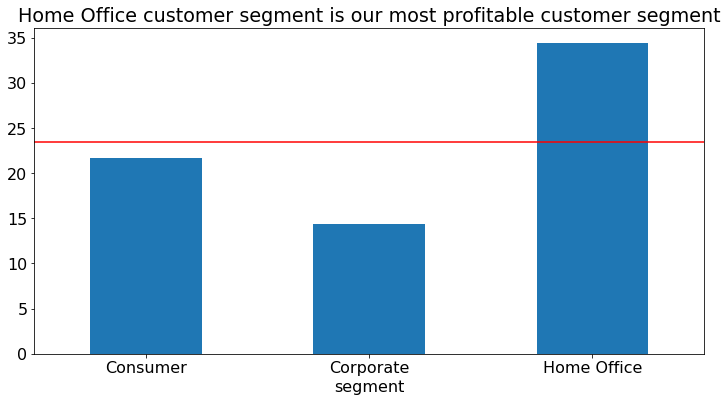

In [26]:
df.groupby("segment").profit.mean().plot.bar()
plt.title('Home Office customer segment is our most profitable customer segment')
plt.axhline(df.groupby("segment").profit.mean().mean(), color='r')
plt.xticks(rotation=0)

In [27]:
for seg in df["segment"].unique():
    overall_mean = df.profit.mean()
    sample = df[df["segment"] == seg].profit
    t,p = stats.ttest_1samp(sample, overall_mean)
    print(seg, t, p)
    if (t>0)&(p/2<alpha):
        print("Significantly Higher ", seg)
    if (t<0)&(p/2<alpha):
        print("Significantly Lower ", seg)

Consumer -0.03445293621343272 0.9725231861326742
Corporate -0.7047901450011024 0.48128481804380385
Home Office 1.10146674811096 0.2715735655988104


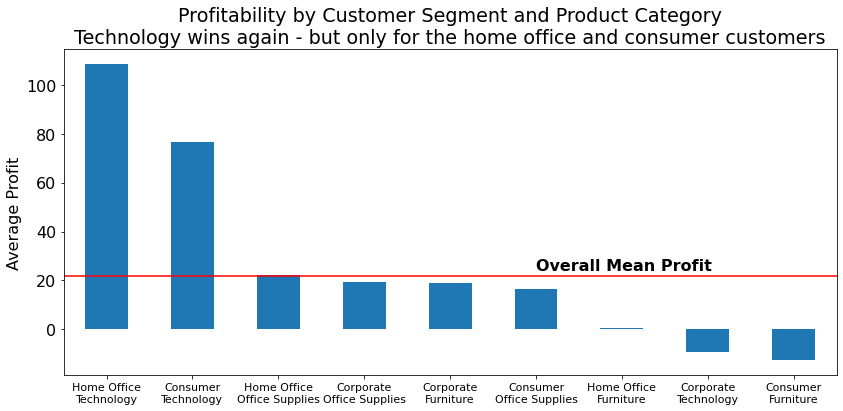

In [33]:
profit_by_seg_cat = df.groupby(["segment","category"]).profit.mean().sort_values(ascending=False)
# Grab the xtick labels
l=profit_by_seg_cat.index.tolist()
# Original index values are multiindex, not great for plotting. This adds a new line between segment and category
xlabs=[i[0]+"\n"+i[1] for i in l]

ax1=profit_by_seg_cat.plot.bar()
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(5,24), fontweight='bold')
ax1.set_xticklabels(xlabs)
plt.title("Profitability by Customer Segment and Product Category\nTechnology wins again - but only for the home office and consumer customers")
plt.xlabel("")
plt.xticks(fontsize=11, rotation = 0)
plt.ylabel("Average Profit")
plt.tight_layout()
plt.show()

In [11]:
overall_mean_profit = df.profit.mean()
for seg in df["segment"].unique():
    for cat in df.category.unique():
        sample = df[(df.segment == seg)&(df.category == cat)].profit
        if len(sample) >30:
            t,p = stats.ttest_1samp(sample, overall_mean_profit)
            used = 'ttest'
        else:
            t,p = stats.wilcoxon(sample)
            used = 'wilcoxon'
        if (t>0)&(p/2<alpha):
            print("Significantly Higher ", seg, cat, used)
        if (t<0)&(p/2<alpha):
            print("Significantly Lower ", seg, cat, used)

Significantly Lower  Consumer Furniture ttest
Significantly Higher  Consumer Technology ttest
Significantly Higher  Home Office Technology ttest


### Statistical testing confirms Home Office and Consumer customers with Technology product category is significantly more profitable than the overall average

### How do the categories compare in terms of sales volume (quantity)?

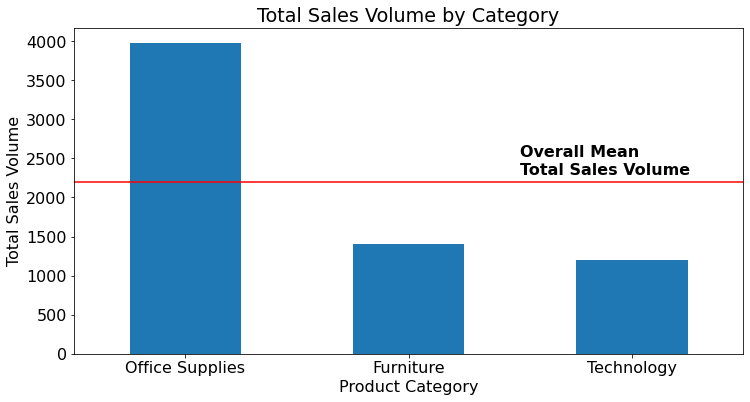

In [38]:
df.groupby("category").quantity.sum().sort_values(ascending=False).plot.bar()
plt.title('Total Sales Volume by Category')
plt.axhline(df.groupby("category").quantity.sum().mean(), color = 'r')
plt.annotate('Overall Mean \nTotal Sales Volume', xy=(1.5,2300), fontweight='bold')
plt.xticks(rotation=0)
plt.xlabel("Product Category")
plt.ylabel("Total Sales Volume")
plt.show()

### We do the least volume in Technology, but this is our most profitable category!

In [35]:
clrs

['#1f77b4',
 '#1f77b4',
 'green',
 '#1f77b4',
 'green',
 '#1f77b4',
 '#1f77b4',
 'green',
 'green']

<AxesSubplot:xlabel='segment,category'>

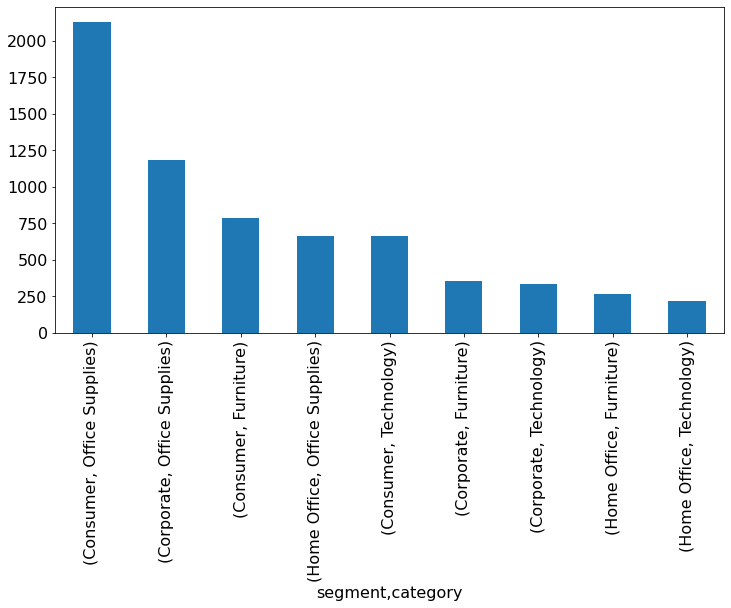

In [44]:
df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False).plot.bar()

In [37]:
profit_by_seg_cat

segment      category       
Home Office  Technology         108.439334
Consumer     Technology          76.563954
Home Office  Office Supplies     22.160356
Corporate    Office Supplies     19.419645
             Furniture           19.063231
Consumer     Office Supplies     16.542236
Home Office  Furniture            0.677105
Corporate    Technology          -9.450729
Consumer     Furniture          -12.709042
Name: profit, dtype: float64

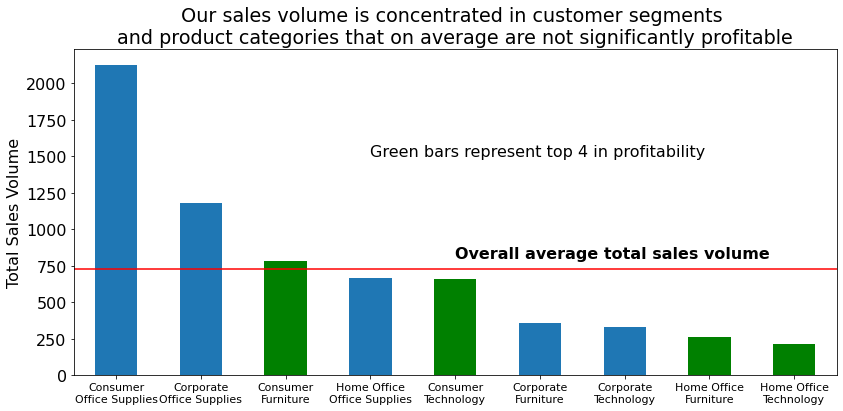

In [52]:
profit_by_seg_cat = df.groupby(["segment","category"]).profit.mean().sort_values(ascending=False)

qty_by_seg_cat = df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False)
# Grab the xtick labels
l=qty_by_seg_cat.index.tolist()
# Original index values are multiindex, not great for plotting. This adds a new line between segment and category
xlabs=[i[0]+"\n"+i[1] for i in l]
# Colors bars based on if they are in the top 4 profitable segment/category combo
clrs=['green' if (x in profit_by_seg_cat.head(4).index) else '#1f77b4' for x in df.groupby(["segment","category"]).quantity.sum().index]

ax1=df.groupby(["segment","category"]).quantity.sum().sort_values(ascending=False).plot.bar(color=clrs)

plt.axhline(df.groupby(["segment","category"]).quantity.sum().mean(), color = 'r')
plt.title("Our sales volume is concentrated in customer segments \nand product categories that on average are not significantly profitable")
plt.annotate("Green bars represent top 4 in profitability", xy=(3, 1500))
plt.annotate("Overall average total sales volume",xy=(4,800), fontweight='bold')
ax1.set_xticklabels(xlabs)
plt.xlabel("")
plt.ylabel("Total Sales Volume")
plt.xticks(fontsize=11, rotation = 0)
plt.tight_layout()
plt.show()

### How are the different Discounts affect the Product profits?

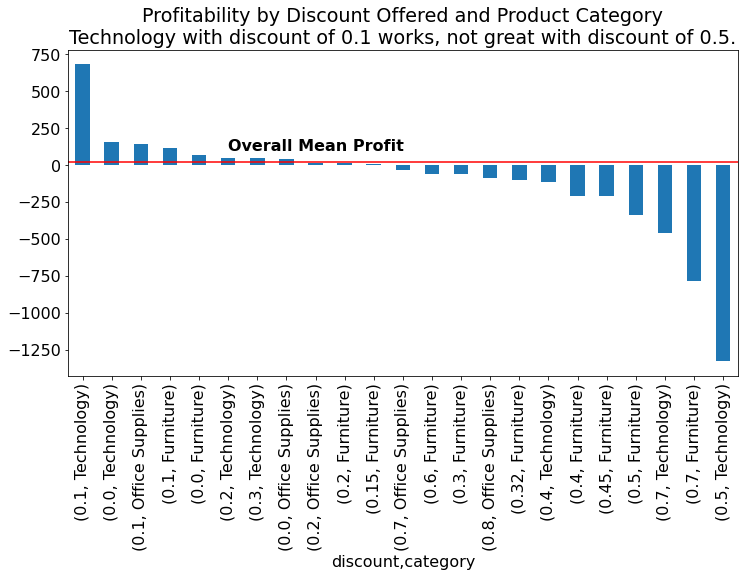

In [22]:
profit_by_disc_cat = df.groupby(["discount","category"]).profit.mean().sort_values(ascending=False)
profit_by_disc_cat.plot.bar()
plt.axhline(df.profit.mean(), color = 'r')
plt.annotate('Overall Mean Profit', xy=(5,100), fontweight='bold')
plt.title("Profitability by Discount Offered and Product Category\nTechnology with discount of 0.1 works, not great with discount of 0.5.")
plt.show()

### Technology even though its performing well overall, factoring in discounts offered, it under-performs with 0.5 discount. 
- Best discount:
    - Technology = 0.1
    - Furniture = 0.1
    - Supplies = 0.0 (offer no discount at the moment)
    
### Overall discount obvervation, the higher the discount, the least profitable the product category is.